## Import Dependencies

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.12) to /tmp/pip-install-v96j8au7/tsfm-public_07227b7ccb6c4b59a948f2e9326eda18
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-v96j8au7/tsfm-public_07227b7ccb6c4b59a948f2e9326eda18
  Running command git checkout -q 9484de7a81e9d202ca024ee7924b83a796661dca
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 9484de7a81e9d202ca024ee7924b83a796661dca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 3950, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 3950 (delta 1157), reused 1100 (delta 1059), pack-reused 2461 (from 1)
Receiving objects: 100% (3950/3950), 29.57 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (2467/2467), done.


In [ ]:
%cd tsfm

/content/tsfm


In [ ]:
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/19

In [ ]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [ ]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-zubnr43d
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-zubnr43d
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ac6ee36acee1e47446cd66f72f540c87f1f1fbe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Using EV sector tickers from 1/1/ 2024 to 8/31/2024, leveraging TTM model to get prediction of daily price from 9/1/2024 to 9/30/2024. 

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import matplotlib.pyplot as plt
from torch.optim import AdamW
from transformers import set_seed
from tsfm_public import TinyTimeMixerForPrediction, count_parameters

# Suppress warnings
os.environ['HF_TOKEN'] = 'dummy_token'
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Constants
FORECAST_LENGTH = 19  # 19 trading days in September
INPUT_LENGTH = 512  # Model's required input length
OUT_DIR = "ttm_finetuned_models/"
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

print("Chosen TTM model:")
print(f"{TTM_MODEL_PATH}, revision = {TTM_MODEL_REVISION}")

def load_stock_data(ticker, start_date, end_date, test_start, test_end):
    """
    Downloads stock data from Yahoo Finance.
    Splits it into training (Jan-Aug) and test (Sep) data.
    """
    data = yf.download(ticker, start=start_date, end=test_end)
    print(f"Downloaded data shape for {ticker}: {data.shape}")

    if data.empty:
        raise ValueError(f"No data available for {ticker} between {start_date} and {test_end}")

    # Extract training data (Jan-Aug) and test data (Sep)
    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start:test_end]

    # Extract close prices for training
    close_prices = train_data['Close'].values
    print(f"Number of close prices for {ticker}: {len(close_prices)}")

    # Pad the sequence to length 512 for the model input
    padded_prices = np.pad(close_prices, (INPUT_LENGTH - len(close_prices), 0), 'constant', constant_values=close_prices[0])

    # Convert to tensor and reshape to (512, 1)
    features = torch.tensor(padded_prices, dtype=torch.float32).unsqueeze(1)

    print(f"Features shape: {features.shape}")

    return features, test_data['Close'].values  # Return the features for training and actual prices for September

def fewshot_finetune_eval(
    ticker,
    start_date,
    end_date,
    test_start,
    test_end,
    learning_rate=0.001,
    num_epochs=100,
    save_dir=OUT_DIR,
):
    out_dir = os.path.join(save_dir, ticker)
    os.makedirs(out_dir, exist_ok=True)

    print("-" * 20, f"Processing {ticker}", "-" * 20)

    # Load training features and actual values for September
    features, actual_values = load_stock_data(ticker, start_date, end_date, test_start, test_end)

    # Ensure features have the correct shape (512, 1)
    if features.shape != (INPUT_LENGTH, 1):
        raise ValueError(f"Expected features shape ({INPUT_LENGTH}, 1), but got {features.shape}")

    model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    print("Number of model parameters:", count_parameters(model))

    # Fine-tuning step
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(features.unsqueeze(0))  # Add batch dimension

        # Extract the prediction outputs from the model's output object
        predictions = outputs.prediction_outputs

        # Use the last 19 actual data points as targets (since you're training on Jan-Aug data)
        targets = features[-FORECAST_LENGTH:, 0]

        # Calculate loss
        loss = torch.nn.functional.mse_loss(predictions[0, -FORECAST_LENGTH:, 0], targets)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Predict next 19 days (i.e., September)
    model.eval()
    with torch.no_grad():
        outputs = model(features.unsqueeze(0))

    # Extract the prediction outputs
    predictions = outputs.prediction_outputs

    # Select only the last 19 predictions (i.e., the predicted September prices)
    predictions = predictions.squeeze()[-FORECAST_LENGTH:]

    # Convert predictions to numpy array
    predictions = predictions.numpy()

    print(f"Final predictions shape: {predictions.shape}")

    return predictions, actual_values, loss.item()

import plotly.graph_objects as go

def plot_predictions(ticker, predictions, actual_values, loss):
    # Create a new figure
    fig = go.Figure()

    # Customize actual values (green dotted line with triangle markers)
    fig.add_trace(go.Scatter(
        x=list(range(1, len(actual_values) + 1)),
        y=actual_values,
        mode='lines+markers',
        name='Actual Values',
        marker=dict(color='green', symbol='triangle-up', size=10),
        line=dict(dash='dot', width=4, color='green')
    ))

    # Customize predicted values (purple dashdot line with diamond markers)
    fig.add_trace(go.Scatter(
        x=list(range(1, len(predictions) + 1)),
        y=predictions,
        mode='lines+markers',
        name='Predicted Values',
        marker=dict(color='purple', symbol='diamond', size=10),
        line=dict(dash='dashdot', width=4, color='purple')
    ))

    # Update layout with new colors and more visually appealing style
    fig.update_layout(
        title={
            'text': f'Predicted vs Actual Values for {ticker} (September 2024)',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial', color='darkblue')
        },
        xaxis_title='Days in September',
        yaxis_title='Stock Price',
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=True, zeroline=True, gridcolor='LightGray'),
        plot_bgcolor='white',
        hovermode='x',
        legend=dict(
            x=0.5, y=1.1,
            xanchor='center',
            orientation="h",
            font=dict(size=14, color='black')
        ),
    )

    # Add a more prominent and styled loss annotation
    fig.add_annotation(
        text=f"Loss: {loss:.4f}",
        xref="paper", yref="paper",
        x=0.5, y=-0.2,
        showarrow=False,
        font=dict(size=14, color="white"),
        align='center',
        bordercolor='darkblue',
        borderwidth=2,
        borderpad=10,
        bgcolor='darkblue',
        opacity=0.9
    )

    # Show the figure
    fig.show()



# Main execution
if __name__ == "__main__":
    tickers = [
        "RIVN", "TSLA", "NIO", "XPEV", "EVGO",
        "LI", "INDI", "CHPT", "LCID", "LAZR"
    ]

    start_date = "2024-01-01"
    end_date = "2024-08-31"  # For training (January to August)
    test_start = "2024-09-01"
    test_end = "2024-09-30"  # For testing/predictions (September)

    results = {}

    for ticker in tickers:
        try:
            predictions, actual_values, loss = fewshot_finetune_eval(
                ticker=ticker,
                start_date=start_date,
                end_date=end_date,
                test_start=test_start,
                test_end=test_end,
                learning_rate=0.001,
                num_epochs=100
            )
            results[ticker] = {
                'predictions': predictions,
                'actual_values': actual_values,
                'loss': loss
            }
            plot_predictions(ticker, predictions, actual_values, loss)

        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
            continue


[*********************100%***********************]  1 of 1 completed

Chosen TTM model:
ibm-granite/granite-timeseries-ttm-r2, revision = main
-------------------- Processing RIVN --------------------
Downloaded data shape for RIVN: (187, 6)
Number of close prices for RIVN: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 1.1625
Epoch 20/100, Loss: 1.3671
Epoch 30/100, Loss: 3.1742
Epoch 40/100, Loss: 6.2329
Epoch 50/100, Loss: 5.6048
Epoch 60/100, Loss: 0.6856
Epoch 70/100, Loss: 3.0228
Epoch 80/100, Loss: 2.1578
Epoch 90/100, Loss: 4.2390
Epoch 100/100, Loss: 5.8351
Final predictions shape: (19,)


-------------------- Processing TSLA --------------------


[*********************100%***********************]  1 of 1 completed

Downloaded data shape for TSLA: (187, 6)
Number of close prices for TSLA: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 47.9852
Epoch 20/100, Loss: 23.8960
Epoch 30/100, Loss: 630.6116
Epoch 40/100, Loss: 76.8841
Epoch 50/100, Loss: 118.8521
Epoch 60/100, Loss: 661.0382
Epoch 70/100, Loss: 170.2163
Epoch 80/100, Loss: 114.6826
Epoch 90/100, Loss: 96.9922
Epoch 100/100, Loss: 50.5189
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing NIO --------------------
Downloaded data shape for NIO: (187, 6)
Number of close prices for NIO: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.1887
Epoch 20/100, Loss: 3.8749
Epoch 30/100, Loss: 1.5126
Epoch 40/100, Loss: 1.4223
Epoch 50/100, Loss: 0.7378
Epoch 60/100, Loss: 0.9411
Epoch 70/100, Loss: 0.9739
Epoch 80/100, Loss: 0.7355
Epoch 90/100, Loss: 0.3746
Epoch 100/100, Loss: 0.3298
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing XPEV --------------------
Downloaded data shape for XPEV: (187, 6)
Number of close prices for XPEV: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 2.2532
Epoch 20/100, Loss: 0.2736
Epoch 30/100, Loss: 0.4789
Epoch 40/100, Loss: 1.2825
Epoch 50/100, Loss: 1.5093
Epoch 60/100, Loss: 1.9863
Epoch 70/100, Loss: 0.2938
Epoch 80/100, Loss: 0.4756
Epoch 90/100, Loss: 0.9560
Epoch 100/100, Loss: 3.1785
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing EVGO --------------------
Downloaded data shape for EVGO: (187, 6)
Number of close prices for EVGO: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0738
Epoch 20/100, Loss: 0.0634
Epoch 30/100, Loss: 0.0204
Epoch 40/100, Loss: 0.5236
Epoch 50/100, Loss: 0.0385
Epoch 60/100, Loss: 0.1728
Epoch 70/100, Loss: 0.0652
Epoch 80/100, Loss: 0.0254
Epoch 90/100, Loss: 0.0104
Epoch 100/100, Loss: 0.0934
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing LI --------------------
Downloaded data shape for LI: (187, 6)
Number of close prices for LI: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 7.9464
Epoch 20/100, Loss: 5.2866
Epoch 30/100, Loss: 10.2162
Epoch 40/100, Loss: 10.4548
Epoch 50/100, Loss: 5.5299
Epoch 60/100, Loss: 4.3231
Epoch 70/100, Loss: 12.4623
Epoch 80/100, Loss: 5.8726
Epoch 90/100, Loss: 3.0803
Epoch 100/100, Loss: 0.8497
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing INDI --------------------
Downloaded data shape for INDI: (187, 6)
Number of close prices for INDI: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.2522
Epoch 20/100, Loss: 0.1942
Epoch 30/100, Loss: 0.0416
Epoch 40/100, Loss: 0.2493
Epoch 50/100, Loss: 0.1131
Epoch 60/100, Loss: 0.8460
Epoch 70/100, Loss: 0.1406
Epoch 80/100, Loss: 0.3434
Epoch 90/100, Loss: 0.5516
Epoch 100/100, Loss: 0.0721
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing CHPT --------------------
Downloaded data shape for CHPT: (187, 6)
Number of close prices for CHPT: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0004
Epoch 20/100, Loss: 0.0073
Epoch 30/100, Loss: 0.0085
Epoch 40/100, Loss: 0.0052
Epoch 50/100, Loss: 0.0117
Epoch 60/100, Loss: 0.0208
Epoch 70/100, Loss: 0.0532
Epoch 80/100, Loss: 0.0170
Epoch 90/100, Loss: 0.0105
Epoch 100/100, Loss: 0.0178
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing LCID --------------------
Downloaded data shape for LCID: (187, 6)
Number of close prices for LCID: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0071
Epoch 20/100, Loss: 0.0935
Epoch 30/100, Loss: 0.0189
Epoch 40/100, Loss: 0.0221
Epoch 50/100, Loss: 0.0311
Epoch 60/100, Loss: 0.0241
Epoch 70/100, Loss: 0.0116
Epoch 80/100, Loss: 0.0367
Epoch 90/100, Loss: 0.0907
Epoch 100/100, Loss: 0.0165
Final predictions shape: (19,)


[*********************100%***********************]  1 of 1 completed

-------------------- Processing LAZR --------------------
Downloaded data shape for LAZR: (187, 6)
Number of close prices for LAZR: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.3737
Epoch 20/100, Loss: 0.0688
Epoch 30/100, Loss: 0.5674
Epoch 40/100, Loss: 0.0608
Epoch 50/100, Loss: 0.0800
Epoch 60/100, Loss: 0.0889
Epoch 70/100, Loss: 0.0345
Epoch 80/100, Loss: 0.1026
Epoch 90/100, Loss: 0.1794
Epoch 100/100, Loss: 0.0259
Final predictions shape: (19,)


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import matplotlib.pyplot as plt
from torch.optim import AdamW
from transformers import set_seed
from tsfm_public import TinyTimeMixerForPrediction, count_parameters

# Suppress warnings
os.environ['HF_TOKEN'] = 'dummy_token'
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Constants
FORECAST_LENGTH = 19  # 19 trading days in September
INPUT_LENGTH = 512  # Model's required input length
OUT_DIR = "ttm_finetuned_models/"
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

print("Chosen TTM model:")
print(f"{TTM_MODEL_PATH}, revision = {TTM_MODEL_REVISION}")

def load_stock_data_with_dates(ticker, start_date, end_date, test_start, test_end):
    """
    Downloads stock data from Yahoo Finance.
    Splits it into training (Jan-Aug) and test (Sep) data.
    """
    data = yf.download(ticker, start=start_date, end=test_end)
    print(f"Downloaded data shape for {ticker}: {data.shape}")

    if data.empty:
        raise ValueError(f"No data available for {ticker} between {start_date} and {test_end}")

    # Extract training data (Jan-Aug) and test data (Sep)
    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start:test_end]  # This contains actual September data with dates

    # Extract close prices for training
    close_prices = train_data['Close'].values
    print(f"Number of close prices for {ticker}: {len(close_prices)}")

    # Pad the sequence to length 512 for the model input
    padded_prices = np.pad(close_prices, (INPUT_LENGTH - len(close_prices), 0), 'constant', constant_values=close_prices[0])

    # Convert to tensor and reshape to (512, 1)
    features = torch.tensor(padded_prices, dtype=torch.float32).unsqueeze(1)

    print(f"Features shape: {features.shape}")

    return features, test_data['Close'].values, train_data['Close'].values, test_data  # Return the features for training, actual prices for September, and test data (for dates)

def compute_mase(predictions, actual_values, training_values):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    MASE is the MAE of predictions scaled by the MAE of a naive model (previous value forecast).
    """
    # Mean Absolute Error (MAE) of the predictions
    mae = np.mean(np.abs(predictions - actual_values))

    # Naive forecast (using the lag-1 difference as forecast)
    naive_forecast = training_values[1:] - training_values[:-1]
    mae_naive = np.mean(np.abs(naive_forecast))

    # MASE
    mase = mae / mae_naive
    return mase

def fewshot_finetune_eval(
    ticker,
    start_date,
    end_date,
    test_start,
    test_end,
    learning_rate=0.001,
    num_epochs=100,
    save_dir=OUT_DIR,
):
    out_dir = os.path.join(save_dir, ticker)
    os.makedirs(out_dir, exist_ok=True)

    print("-" * 20, f"Processing {ticker}", "-" * 20)

    # Load training features, actual values for September, and full training values for MASE
    features, actual_values, training_values, test_data = load_stock_data_with_dates(ticker, start_date, end_date, test_start, test_end)

    # Extract actual dates (index) for plotting
    actual_dates = test_data.index

    # Ensure features have the correct shape (512, 1)
    if features.shape != (INPUT_LENGTH, 1):
        raise ValueError(f"Expected features shape ({INPUT_LENGTH}, 1), but got {features.shape}")

    model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    print("Number of model parameters:", count_parameters(model))

    # Fine-tuning step
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(features.unsqueeze(0))  # Add batch dimension

        # Extract the prediction outputs from the model's output object
        predictions = outputs.prediction_outputs

        # Use the last 19 actual data points as targets (since you're training on Jan-Aug data)
        targets = features[-FORECAST_LENGTH:, 0]

        # Calculate MSE Loss (Mean Squared Error)
        loss = torch.nn.functional.mse_loss(predictions[0, -FORECAST_LENGTH:, 0], targets)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Predict next 19 days (i.e., September)
    model.eval()
    with torch.no_grad():
        outputs = model(features.unsqueeze(0))

    # Extract the prediction outputs
    predictions = outputs.prediction_outputs

    # Select only the last 19 predictions (i.e., the predicted September prices)
    predictions = predictions.squeeze()[-FORECAST_LENGTH:]

    # Convert predictions to numpy array
    predictions = predictions.numpy()

    # Calculate MASE for reference
    mase = compute_mase(predictions, actual_values, training_values)

    print(f"Final predictions shape: {predictions.shape}")
    print(f"MASE for {ticker}: {mase:.4f}")  # Reference only, not used for performance metric

    return predictions, actual_values, actual_dates, loss, mase

import plotly.graph_objects as go

def plot_predictions(ticker, predictions, actual_values, loss):
    # Create a new figure
    fig = go.Figure()

    # Customize actual values (green dotted line with triangle markers)
    fig.add_trace(go.Scatter(
        x=list(range(1, len(actual_values) + 1)),
        y=actual_values,
        mode='lines+markers',
        name='Actual Values',
        marker=dict(color='green', symbol='triangle-up', size=10),
        line=dict(dash='dot', width=4, color='green')
    ))

    # Customize predicted values (purple dashdot line with diamond markers)
    fig.add_trace(go.Scatter(
        x=list(range(1, len(predictions) + 1)),
        y=predictions,
        mode='lines+markers',
        name='Predicted Values',
        marker=dict(color='purple', symbol='diamond', size=10),
        line=dict(dash='dashdot', width=4, color='purple')
    ))

    # Update layout with new colors and more visually appealing style
    fig.update_layout(
        title={
            'text': f'Predicted vs Actual Values for {ticker} (September 2024)',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial', color='darkblue')
        },
        xaxis_title='Days in September',
        yaxis_title='Stock Price',
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=True, zeroline=True, gridcolor='LightGray'),
        plot_bgcolor='white',
        hovermode='x',
        legend=dict(
            x=0.5, y=1.1,
            xanchor='center',
            orientation="h",
            font=dict(size=14, color='black')
        ),
    )

    # Add a more prominent and styled loss annotation
    fig.add_annotation(
        text=f"Loss: {loss:.4f}",
        xref="paper", yref="paper",
        x=0.5, y=-0.2,
        showarrow=False,
        font=dict(size=14, color="white"),
        align='center',
        bordercolor='darkblue',
        borderwidth=2,
        borderpad=10,
        bgcolor='darkblue',
        opacity=0.9
    )

    # Show the figure
    fig.show()

# Main execution
if __name__ == "__main__":
    tickers = [
        "RIVN", "TSLA", "NIO", "XPEV", "EVGO",
        "LI", "INDI", "CHPT", "LCID", "LAZR"
    ]

    start_date = "2024-01-01"
    end_date = "2024-08-31"  # For training (January to August)
    test_start = "2024-09-01"
    test_end = "2024-09-30"  # For testing/predictions (September)

    results = {}
    mase = {}

    for ticker in tickers:
        try:
            predictions, actual_values, actual_dates, loss, mase = fewshot_finetune_eval(
                ticker=ticker,
                start_date=start_date,
                end_date=end_date,
                test_start=test_start,
                test_end=test_end,
                learning_rate=0.001,
                num_epochs=100
            )
            results[ticker] = {
                'predictions': predictions,
                'actual_values': actual_values,
                'loss': loss,
                'mase': mase  # For reference only
            }
            mase[ticker] = {
                'mase': mase
            }
            plot_predictions(ticker, predictions, actual_values, actual_dates, loss)

        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
            continue


[*********************100%***********************]  1 of 1 completed

Chosen TTM model:
ibm-granite/granite-timeseries-ttm-r2, revision = main
-------------------- Processing RIVN --------------------
Downloaded data shape for RIVN: (187, 6)
Number of close prices for RIVN: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.6667
Epoch 20/100, Loss: 2.8629
Epoch 30/100, Loss: 0.5089
Epoch 40/100, Loss: 2.5842
Epoch 50/100, Loss: 4.6246
Epoch 60/100, Loss: 2.5830
Epoch 70/100, Loss: 1.9036
Epoch 80/100, Loss: 1.0410
Epoch 90/100, Loss: 1.4560


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 1.5329
Final predictions shape: (19,)
MASE for RIVN: 3.2649
Error processing RIVN: 'numpy.float64' object does not support item assignment
-------------------- Processing TSLA --------------------
Downloaded data shape for TSLA: (187, 6)
Number of close prices for TSLA: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 310.5867
Epoch 20/100, Loss: 169.4695
Epoch 30/100, Loss: 79.1143
Epoch 40/100, Loss: 82.5629
Epoch 50/100, Loss: 170.1840
Epoch 60/100, Loss: 139.9087
Epoch 70/100, Loss: 61.9489
Epoch 80/100, Loss: 34.9213
Epoch 90/100, Loss: 159.0349


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 49.1379
Final predictions shape: (19,)
MASE for TSLA: 5.5727
Error processing TSLA: 'numpy.float64' object does not support item assignment
-------------------- Processing NIO --------------------
Downloaded data shape for NIO: (187, 6)
Number of close prices for NIO: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.3140
Epoch 20/100, Loss: 0.0384
Epoch 30/100, Loss: 1.7378
Epoch 40/100, Loss: 0.7823
Epoch 50/100, Loss: 0.6701
Epoch 60/100, Loss: 2.0526
Epoch 70/100, Loss: 0.7166
Epoch 80/100, Loss: 1.4606
Epoch 90/100, Loss: 0.2384


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 0.3238
Final predictions shape: (19,)
MASE for NIO: 10.5721
Error processing NIO: 'numpy.float64' object does not support item assignment
-------------------- Processing XPEV --------------------
Downloaded data shape for XPEV: (187, 6)
Number of close prices for XPEV: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 1.4430
Epoch 20/100, Loss: 2.7771
Epoch 30/100, Loss: 1.6685
Epoch 40/100, Loss: 1.4744
Epoch 50/100, Loss: 0.3029
Epoch 60/100, Loss: 1.1420
Epoch 70/100, Loss: 2.6851
Epoch 80/100, Loss: 2.7736
Epoch 90/100, Loss: 1.4285


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 3.1629
Final predictions shape: (19,)
MASE for XPEV: 7.1668
Error processing XPEV: 'numpy.float64' object does not support item assignment
-------------------- Processing EVGO --------------------
Downloaded data shape for EVGO: (187, 6)
Number of close prices for EVGO: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0567
Epoch 20/100, Loss: 0.0212
Epoch 30/100, Loss: 0.0157
Epoch 40/100, Loss: 0.0755
Epoch 50/100, Loss: 0.0377
Epoch 60/100, Loss: 0.0311
Epoch 70/100, Loss: 0.0384
Epoch 80/100, Loss: 0.0134
Epoch 90/100, Loss: 0.0070


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 0.0247
Final predictions shape: (19,)
MASE for EVGO: 4.9892
Error processing EVGO: 'numpy.float64' object does not support item assignment
-------------------- Processing LI --------------------
Downloaded data shape for LI: (187, 6)
Number of close prices for LI: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 3.9975
Epoch 20/100, Loss: 6.2447
Epoch 30/100, Loss: 5.3265
Epoch 40/100, Loss: 3.0423
Epoch 50/100, Loss: 6.7165
Epoch 60/100, Loss: 8.2003
Epoch 70/100, Loss: 13.3067
Epoch 80/100, Loss: 1.6589
Epoch 90/100, Loss: 1.8705


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 1.5749
Final predictions shape: (19,)
MASE for LI: 2.2261
Error processing LI: 'numpy.float64' object does not support item assignment
-------------------- Processing INDI --------------------
Downloaded data shape for INDI: (187, 6)
Number of close prices for INDI: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.4064
Epoch 20/100, Loss: 0.1482
Epoch 30/100, Loss: 0.1228
Epoch 40/100, Loss: 0.2740
Epoch 50/100, Loss: 0.0952
Epoch 60/100, Loss: 0.1621
Epoch 70/100, Loss: 1.3811
Epoch 80/100, Loss: 0.1786
Epoch 90/100, Loss: 0.1365


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 0.3405
Final predictions shape: (19,)
MASE for INDI: 1.4323
Error processing INDI: 'numpy.float64' object does not support item assignment
-------------------- Processing CHPT --------------------
Downloaded data shape for CHPT: (187, 6)
Number of close prices for CHPT: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0095
Epoch 20/100, Loss: 0.0012
Epoch 30/100, Loss: 0.0084
Epoch 40/100, Loss: 0.0013
Epoch 50/100, Loss: 0.0028
Epoch 60/100, Loss: 0.0035
Epoch 70/100, Loss: 0.0053
Epoch 80/100, Loss: 0.0110
Epoch 90/100, Loss: 0.0664


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 0.0139
Final predictions shape: (19,)
MASE for CHPT: 6.0955
Error processing CHPT: 'numpy.float64' object does not support item assignment
-------------------- Processing LCID --------------------
Downloaded data shape for LCID: (187, 6)
Number of close prices for LCID: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0036
Epoch 20/100, Loss: 0.0223
Epoch 30/100, Loss: 0.0156
Epoch 40/100, Loss: 0.0274
Epoch 50/100, Loss: 0.0381
Epoch 60/100, Loss: 0.0166
Epoch 70/100, Loss: 0.0120
Epoch 80/100, Loss: 0.0193
Epoch 90/100, Loss: 0.0386


[*********************100%***********************]  1 of 1 completed

Epoch 100/100, Loss: 0.0199
Final predictions shape: (19,)
MASE for LCID: 5.1245
Error processing LCID: 'numpy.float64' object does not support item assignment
-------------------- Processing LAZR --------------------
Downloaded data shape for LAZR: (187, 6)
Number of close prices for LAZR: 168
Features shape: torch.Size([512, 1])


Number of model parameters: 805280
Epoch 10/100, Loss: 0.0660
Epoch 20/100, Loss: 0.0308
Epoch 30/100, Loss: 0.0351
Epoch 40/100, Loss: 0.1222
Epoch 50/100, Loss: 0.2256
Epoch 60/100, Loss: 0.0266
Epoch 70/100, Loss: 0.0771
Epoch 80/100, Loss: 0.1705
Epoch 90/100, Loss: 0.4565
Epoch 100/100, Loss: 1.1376
Final predictions shape: (19,)
MASE for LAZR: 1.3017
Error processing LAZR: 'numpy.float64' object does not support item assignment


In [ ]:
mase

1.301742929170066

In [ ]:
for i in results:
  print(i, results[i]['loss'])

RIVN tensor(1.5329, grad_fn=<MseLossBackward0>)
TSLA tensor(49.1379, grad_fn=<MseLossBackward0>)
NIO tensor(0.3238, grad_fn=<MseLossBackward0>)
XPEV tensor(3.1629, grad_fn=<MseLossBackward0>)
EVGO tensor(0.0247, grad_fn=<MseLossBackward0>)
LI tensor(1.5749, grad_fn=<MseLossBackward0>)
INDI tensor(0.3405, grad_fn=<MseLossBackward0>)
CHPT tensor(0.0139, grad_fn=<MseLossBackward0>)
LCID tensor(0.0199, grad_fn=<MseLossBackward0>)
LAZR tensor(1.1376, grad_fn=<MseLossBackward0>)


In [ ]:
for i in results:
  print(i, results[i]['mase'])

RIVN 3.2649196587365843
TSLA 5.572694488866907
NIO 10.572096034530942
XPEV 7.166837257623616
EVGO 4.9892497767345745
LI 2.2260752553464975
INDI 1.4322693009181022
CHPT 6.095467330741494
LCID 5.124540603819688
LAZR 1.301742929170066


Chosen TTM model:
ibm-granite/granite-timeseries-ttm-r2, revision = main


In [ ]:
!pip install yfinance

## Compare the forecasting accuracy of TTM with Chronos and ARIMA

In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Rivian Automotive
tickers = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc ADR
    "XPEV",  # Xpeng A ADR
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto ADR
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # ChargePoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies A
]
ticker = "RIVN"
# Define the start and end dates
start_date = "2024-01-01"
end_date = "2024-08-31"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Filter out only the 'Close' price
close_prices = stock_data[['Close']]

# Display the first few rows of the close price data
print(close_prices.head())


[*********************100%***********************]  1 of 1 completed

            Close
Date             
2024-01-02  21.10
2024-01-03  20.32
2024-01-04  19.50
2024-01-05  19.08
2024-01-08  19.58


In [ ]:
close_prices.reset_index(inplace=True)

In [ ]:
close_prices

,Date,Close
0,2024-01-02,21.10
1,2024-01-03,20.32
2,2024-01-04,19.50
3,2024-01-05,19.08
4,2024-01-08,19.58
...,...,...
163,2024-08-26,14.36
164,2024-08-27,14.48
165,2024-08-28,13.83
166,2024-08-29,14.09


In [ ]:
def load_dataset(dataset_name, context_length, forecast_length, fewshot_fraction, dataset_path):
    # In your case, you can skip the dataset_path as the data is already loaded
    # Assuming your dataset is already loaded as `close_values`
    from sklearn.model_selection import train_test_split

    # Create sliding windows of the context and forecast lengths
    X = []
    y = []
    for i in range(len(close_values) - context_length - forecast_length):
        X.append(close_values[i : i + context_length])
        y.append(close_values[i + context_length : i + context_length + forecast_length])

    # Split into train/test sets
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert into the required format (e.g., PyTorch tensors)
    # For simplicity, returning X_test and y_test directly here
    return None, None, {'input_ids': X_test, 'labels': y_test}


In [ ]:
close_values = close_prices['Close'].values

In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Rivian Automotive
ticker = "RIVN"

# Define the start and end dates
start_date = "2024-09-01"
end_date = "2024-09-30"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Filter out only the 'Close' price
RIVN = stock_data[['Close']]


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2024-09-03,13.15
2024-09-04,13.28
2024-09-05,13.74
2024-09-06,13.23
2024-09-09,13.08
2024-09-10,13.23
2024-09-11,13.93
2024-09-12,13.72
2024-09-13,13.50


In [ ]:
forecast = pipeline.predict(
    context=torch.tensor(close_prices["Close"]),
    prediction_length=19,
    num_samples=20,
)

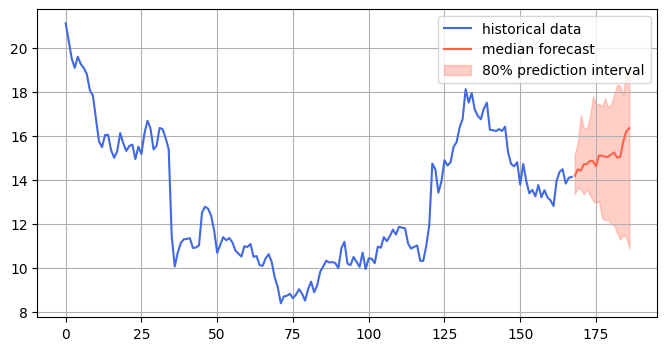

In [ ]:
forecast_index = range(len(close_prices), len(close_prices) + 19)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(close_prices["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

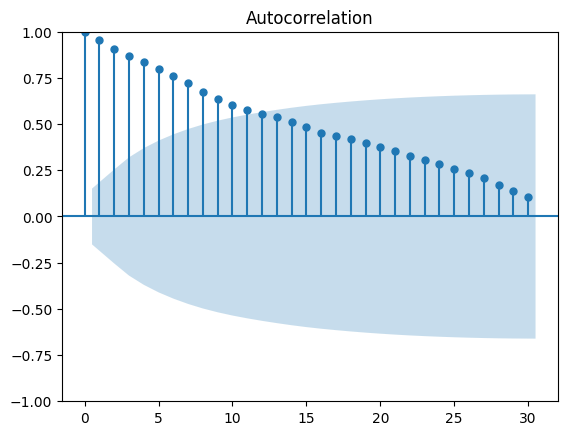

In [ ]:
# check if there's a seasonal pattern
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'close_prices' is your DataFrame
plot_acf(close_prices["Close"], lags=30)  # Try with different lag ranges
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model_arima = ARIMA(close_prices['Close'], order=(5, 1, 0))  # Example order (p, d, q), adjust as needed
arima_fit = model_arima.fit()

forecast_arima = arima_fit.forecast(steps=19)
forecast_arima.values

array([14.14025863, 14.11151071, 14.12338282, 14.12188018, 14.12134997,
       14.12006583, 14.12084522, 14.12080663, 14.12082544, 14.12078252,
       14.1208188 , 14.12080866, 14.12080736, 14.12080501, 14.12080686,
       14.12080642, 14.12080652, 14.12080647, 14.12080656])

In [ ]:
 import numpy as np

def mase(actual, forecast, seasonality=1, epsilon=1e-8):
    """
    Calculate Mean Absolute Scaled Error (MASE).

    Parameters:
    - actual: Array of actual values
    - forecast: Array of forecasted values
    - seasonality: Seasonal period (e.g., 7 for weekly data)
    - epsilon: Small value to avoid division by zero

    Returns:
    - MASE value
    """
    # Ensure input is numpy array for consistent calculations
    actual = np.array(actual)
    forecast = np.array(forecast)

    # Step 1: Calculate naive forecast errors (aligned with seasonality)
    naive_forecast = actual[:-seasonality]
    naive_errors = np.abs(actual[seasonality:] - naive_forecast)

    # Step 2: Calculate forecast errors
    forecast_errors = np.abs(actual[-len(forecast):] - forecast)

    # Step 3: Calculate and return MASE
    return np.mean(forecast_errors) / (np.mean(naive_errors) + epsilon)

def weighted_quantile_loss(actual, forecast_quantiles, quantiles=[0.1, 0.5, 0.9]):
    n = len(actual)
    wql = 0.0
    for q, forecast in zip(quantiles, forecast_quantiles):
        error = actual - forecast
        wql += np.sum(np.maximum(q * error, (q - 1) * error))
    return (2 / n) * wql


# Calculate MASE for each model
mase_arima = mase(actual_values, forecast_arima.values)
mase_lstm = mase(actual_values, forecast_lstm)
mase_value = mase(actual_values, forecast_median, seasonality=1)

print(f"MASE - ARIMA: {mase_arima}")
print(f"MASE - LSTM: {mase_lstm}")
print(f"MASE - Chronos: {mase_value}")


MASE - ARIMA: 3.783466849572086
MASE - LSTM: 3.808683226996563
MASE - Chronos: 6.344467579217851


In [ ]:
import numpy as np

# Example actual values and forecasts (replace with real data)
actual_values = RIVN['Close']
forecast_median = median  # Median forecast from earlier
forecast_quantiles = np.array([low, median, high])  # Forecast quantiles

# 1. Weighted Quantile Loss (WQL)
def weighted_quantile_loss(actual, forecast_quantiles, quantiles=[0.1, 0.5, 0.9]):
    n = len(actual)
    wql = 0.0
    for q, forecast in zip(quantiles, forecast_quantiles):
        error = actual - forecast
        wql += np.sum(np.maximum(q * error, (q - 1) * error))
    return (2 / n) * wql

wql_value = weighted_quantile_loss(actual_values, forecast_quantiles)
print(f"Weighted Quantile Loss (WQL): {wql_value}")


Weighted Quantile Loss (WQL): 9.347738485309433


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress Keras messages


[*********************100%***********************]  1 of 1 completed


Processing RIVN...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


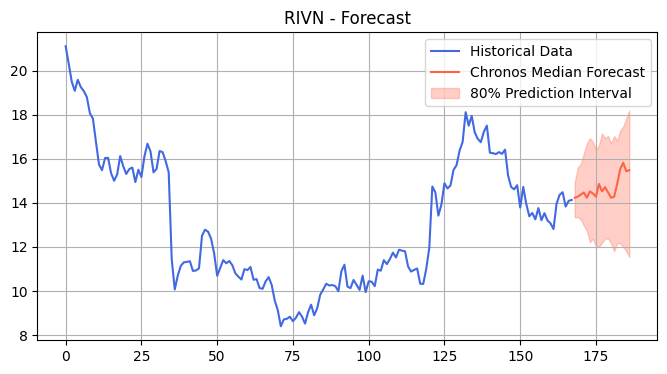

[*********************100%***********************]  1 of 1 completed


Processing TSLA...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


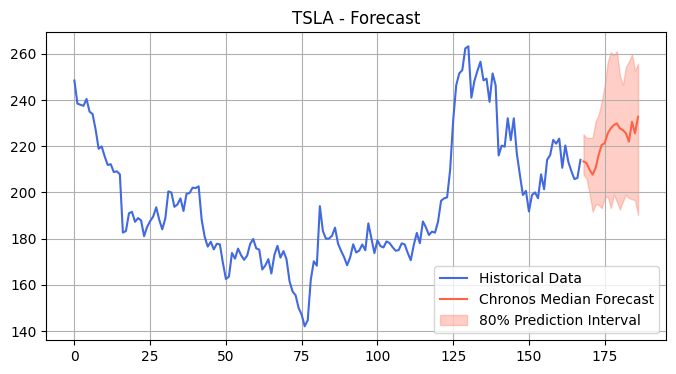

[*********************100%***********************]  1 of 1 completed


Processing NIO...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


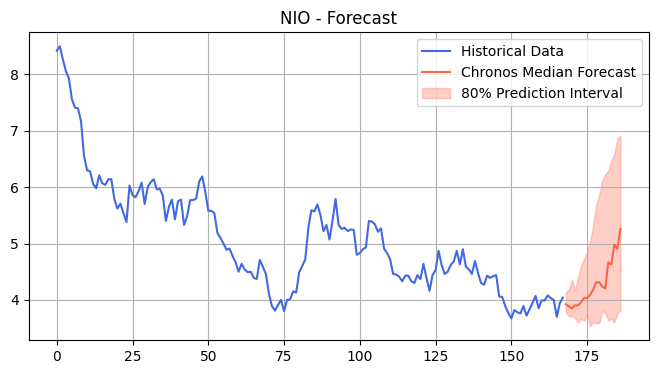

[*********************100%***********************]  1 of 1 completed


Processing XPEV...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


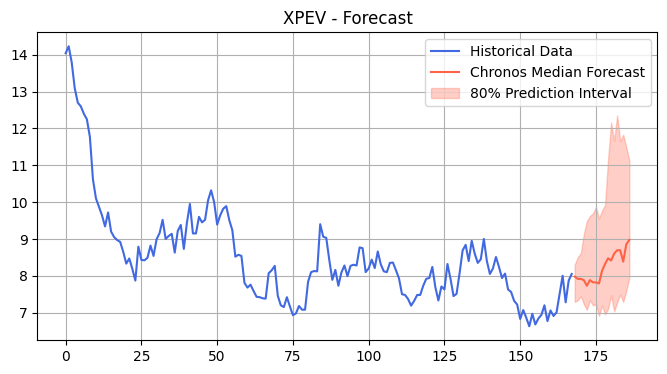

[*********************100%***********************]  1 of 1 completed


Processing EVGO...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


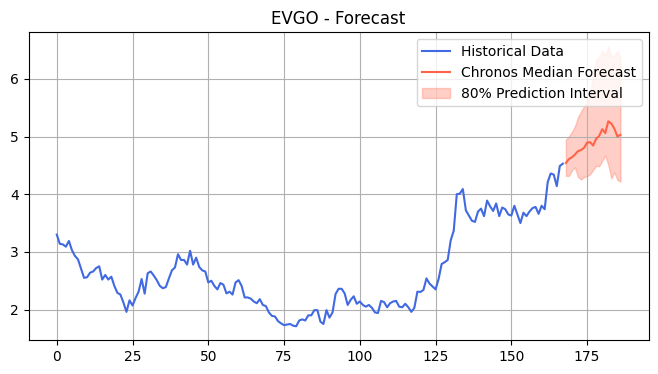

[*********************100%***********************]  1 of 1 completed


Processing LI...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


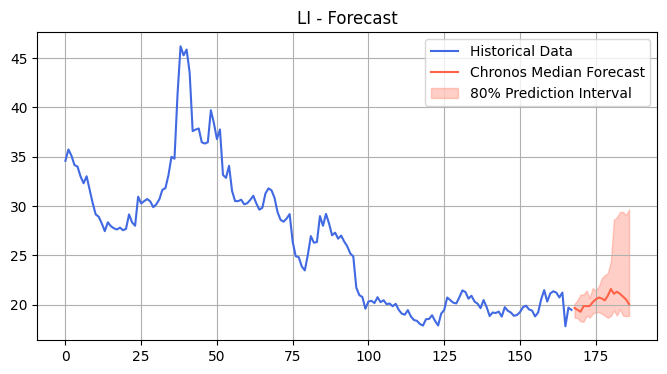

[*********************100%***********************]  1 of 1 completed


Processing INDI...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


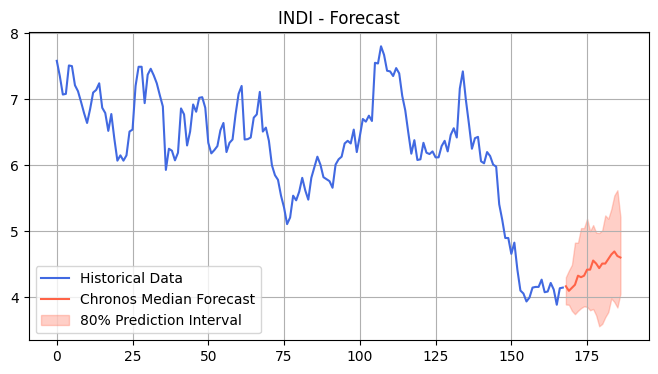

[*********************100%***********************]  1 of 1 completed


Processing CHPT...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


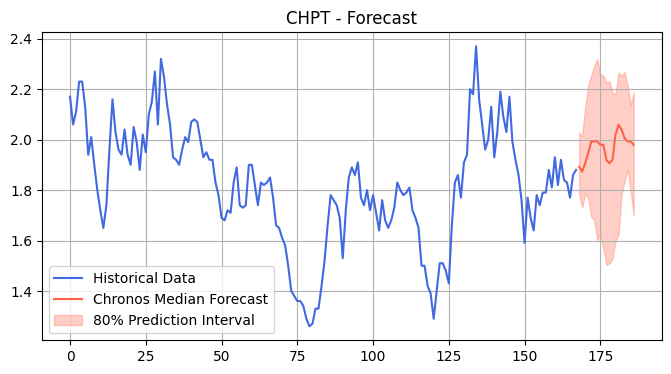

[*********************100%***********************]  1 of 1 completed


Processing LCID...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


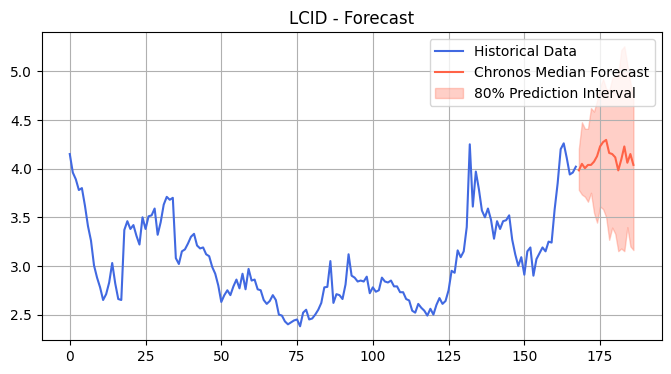

[*********************100%***********************]  1 of 1 completed


Processing LAZR...




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


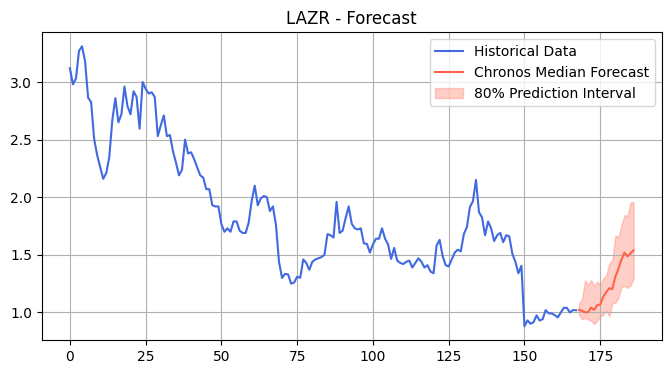


Summary of MASE and WQL for all models:
  Ticker  MASE_ARIMA  MASE_LSTM  MASE_Chronos  WQL_ARIMA   WQL_LSTM  \
0   RIVN    1.141765   1.020476      2.125944   1.610222   1.140633   
1   TSLA    1.433814   4.927614      2.138708  25.370145  63.190923   
2    NIO    1.392192   2.132438      3.284347   0.482414   0.405017   
3   XPEV    2.789522   1.719242      3.438955   2.608274   0.983415   
4   EVGO    4.828043  33.618741      7.463436   1.956777   7.425183   
5     LI    1.270745   1.538846      0.828267   2.626185   2.778036   
6   INDI    1.246075  19.077395      3.038858   0.530669   6.301853   
7   CHPT    1.192612   1.224631      2.154650   0.287686   0.150630   
8   LCID    4.149176  23.565614      4.597611   1.802727   5.991828   
9   LAZR    1.155068   1.468111      4.646556   0.192263   0.176196   

   WQL_Chronos  
0     1.876229  
1    24.667011  
2     0.740928  
3     2.097485  
4     2.351498  
5     1.811750  
6     0.799727  
7     0.324402  
8     1.492487  
9     0

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch

# Define the list of tickers
tickers = [
    "RIVN", "TSLA", "NIO", "XPEV", "EVGO",
    "LI", "INDI", "CHPT", "LCID", "LAZR"
]

# Define the start and end dates for historical data
start_date = "2024-01-01"
end_date = "2024-08-31"
forecast_horizon = 19  # Forecast horizon (19 time steps)

summary_data = []

def mase(actual, forecast, seasonality=1, epsilon=1e-8):
    actual, forecast = np.array(actual), np.array(forecast)
    naive_forecast = actual[:-seasonality]
    naive_errors = np.abs(actual[seasonality:] - naive_forecast)
    forecast_errors = np.abs(actual[-len(forecast):] - forecast)
    return np.mean(forecast_errors) / (np.mean(naive_errors) + epsilon)

def weighted_quantile_loss(actual, forecast_quantiles, quantiles=[0.1, 0.5, 0.9]):
    n = len(actual)
    wql = 0.0
    for q, forecast in zip(quantiles, forecast_quantiles):
        error = actual - forecast
        wql += np.sum(np.maximum(q * error, (q - 1) * error))
    return (2 / n) * wql

def prepare_data(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

for ticker in tickers:
    print(f"\nProcessing {ticker}...\n")

    # Download stock data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    close_prices = stock_data[['Close']].reset_index(drop=True)

    # ------------------------------
    # Chronos Forecast using Pipeline
    # ------------------------------
    forecast = pipeline.predict(
        context=torch.tensor(close_prices["Close"]),
        prediction_length=forecast_horizon,
        num_samples=20,
    )
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # ------------------------------
    # ARIMA Forecast
    # ------------------------------
    model_arima = ARIMA(close_prices['Close'], order=(5, 1, 0))
    arima_fit = model_arima.fit()
    forecast_arima = arima_fit.forecast(steps=forecast_horizon)

    # ------------------------------
    # LSTM Forecast
    # ------------------------------
    window_size = 10
    X, y = prepare_data(close_prices['Close'].values, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')

    model_lstm.fit(X, y, epochs=20, verbose=0)

    lstm_input = close_prices['Close'].values[-window_size:].reshape((1, window_size, 1))
    forecast_lstm = []
    for _ in range(forecast_horizon):
        next_value = model_lstm.predict(lstm_input).flatten()[0]
        forecast_lstm.append(next_value)
        next_value_reshaped = np.array(next_value).reshape(1, 1, 1)
        lstm_input = np.concatenate([lstm_input[:, 1:, :], next_value_reshaped], axis=1)

    # ------------------------------
    # Evaluation: MASE and WQL
    # ------------------------------
    actual_values = close_prices['Close'][-forecast_horizon:].values

    mase_arima = mase(actual_values, forecast_arima.values)
    mase_lstm = mase(actual_values, forecast_lstm)
    mase_chronos = mase(actual_values, median)

    arima_quantiles = np.array([
        np.percentile(forecast_arima.values, 10),
        np.median(forecast_arima.values),
        np.percentile(forecast_arima.values, 90)
    ])
    lstm_quantiles = np.array([
        np.percentile(forecast_lstm, 10),
        np.median(forecast_lstm),
        np.percentile(forecast_lstm, 90)
    ])
    chronos_quantiles = np.array([low, median, high])

    wql_arima = weighted_quantile_loss(actual_values, arima_quantiles)
    wql_lstm = weighted_quantile_loss(actual_values, lstm_quantiles)
    wql_chronos = weighted_quantile_loss(actual_values, chronos_quantiles)

    summary_data.append({
        "Ticker": ticker,
        "MASE_ARIMA": mase_arima,
        "MASE_LSTM": mase_lstm,
        "MASE_Chronos": mase_chronos,
        "WQL_ARIMA": wql_arima,
        "WQL_LSTM": wql_lstm,
        "WQL_Chronos": wql_chronos
    })

    # ------------------------------
    # Plot Results
    # ------------------------------
    forecast_index = range(len(close_prices), len(close_prices) + forecast_horizon)
    plt.figure(figsize=(8, 4))
    plt.plot(close_prices['Close'], label='Historical Data', color='royalblue')
    plt.plot(forecast_index, median, label='Chronos Median Forecast', color='tomato')
    plt.fill_between(forecast_index, low, high, color='tomato', alpha=0.3, label='80% Prediction Interval')
    plt.legend()
    plt.grid()
    plt.title(f"{ticker} - Forecast")
    plt.show()

# ------------------------------
# Summary Table
# ------------------------------
summary_df = pd.DataFrame(summary_data)
print("\nSummary of MASE and WQL for all models:")
print(summary_df)
